# 1D Systematics treatment

## Imports

In [1]:
import torch 
import h5py
import os 
import sys

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

sys.path.insert(0, "/home/lai/nplm/src")
from plot_utils import set_label_font, set_tick_font, draw_grid, plot_nuisance_variations, plot_nuisance_ratio
from analysis_utils import load_binning
from nn_utils import ParametricNet, delta_nu_poly, parametric_loss
from data_utils import normalize_data, calculate_statistics, read_nu_variation, luminosity_scale, create_analysis_objects, combine_analysis_objects

## Config

In [2]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)

cuda


In [3]:
hep.style.use(hep.style.CMS)

## Constants

In [4]:
# Set random seed
SEED = 1231244
torch.manual_seed(SEED)
np.random.seed(SEED)

# Plotting parameters
FONTSIZE  = 24
FIGSIZE   = (10, 8)
PALETTE_1 = [
    "#1f77b4", # 0
    "#4876bf", # 1 
    "#6c74c5", # 2
    "#8f6fc6", # 3
    "#b067c0", # 4
    "#cd5fb4", # 5
    "#e657a3", # 6
    "#f9528d", # 7
    "#ff5474", # 8
    "#ff5d58", # 9
    "#ff6c3a", # 10
    "#ff7f0e", # 11
]
PALETTE_2 = [
    "#494B69", # 0
    "#695D7A", # 1
    "#9F5B72", # 2
    "#D8707C", # 3
    "#FDA85A", # 4
    "#FDCD5A", # 5
]
PALETTE_3 = [
    "midnightblue",   # 0
    "#1f78b4",        # 1
    "lightseagreen",  # 2
    "mediumseagreen", # 3
    "darkseagreen",   # 4
]

# Luminosity
NR0 = 20_000

PLOT_PATH = "./plots/"
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)
    
DATA_PATH = "./data/"
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

In [5]:
INPUT_SIZE  = 1 # x
INPUT_SHAPE = (INPUT_SIZE,)
LAYERS      = [INPUT_SIZE, 30, 30, 1]

# number of training epochs
EPOCHS         = 1000
# after how many epochs to gather the loss and accuracy
PATIENCE       = 100
# weight-clipping
WCLIP          = 7
# polynomial degree of the approximation
POLY_DEGREE    = 1
# activation function
ACTIVATION     = torch.nn.Sigmoid()
# batch fraction 
BATCH_FRACTION = 1 # 0.3
# gather after
GATHER_AFTER   = 1 # int(1. / BATCH_FRACTION)
# learning rate
LEARNING_RATE  = 0.01

## DATASETS

In [6]:
bins       = load_binning(path=DATA_PATH, name="binning_1dexpon.h5")
bincenters = 0.5*(bins[1:]+bins[:-1])
binwidths  = bins[1:]-bins[:-1]

In [7]:
# Array to store the data
feature     = np.array([])
targets     = np.array([])
weights     = np.array([])
nuisance    = np.array([])

# Nuisance parameter setup
nu_list     = np.array([-2, -1, -0.5, 0.5, 1, 2])
nu_std      = np.std(nu_list)
nu_list_std = nu_list * (1. / nu_std)

### Central value

In [8]:
# Read the central value reference hypothesis nu==0
ref, w_ref = read_nu_variation(file_path=DATA_PATH, nu=0)

# Store mean and std of the reference distribution for common standardization
mean_ref, std_ref = calculate_statistics(ref)

### Nuisance variations

In [9]:
# for each value of the nuisance parameter:
for nu in nu_list:
        
    # get the corresponding standard deviation of the nuisance parameter     
    nu_std = nu_list_std[np.where(nu==nu_list)[0][0]]
    
    # read the data and weights for the nuisance parameter variation hypothesis
    data, w_data = read_nu_variation(file_path=DATA_PATH, nu=nu)
    
    # scale the reference and data to the luminosity of the experiment
    ref_scaled, data_scaled, w_ref_scaled, w_data_scaled = luminosity_scale(
        ref      = ref, 
        data     = data, 
        w_ref    = w_ref, 
        w_data   = w_data, 
        nr0      = NR0
    )
    
    # combine the reference and data into one dataset
    feature_nu, targets_nu, weights_nu, nuisance_nu = create_analysis_objects(
        ref      = ref_scaled, 
        data     = data_scaled, 
        w_ref    = w_ref_scaled, 
        w_data   = w_data_scaled, 
        nu_std   = nu_std
    )
    
    # combine the datasets for different nuisance parameter values
    feature, targets, weights, nuisance = combine_analysis_objects(
        feature     = feature, 
        targets     = targets, 
        weights     = weights, 
        nuisance    = nuisance, 
        new_samples = (feature_nu, targets_nu, weights_nu, nuisance_nu)
    )

### Plot datasets

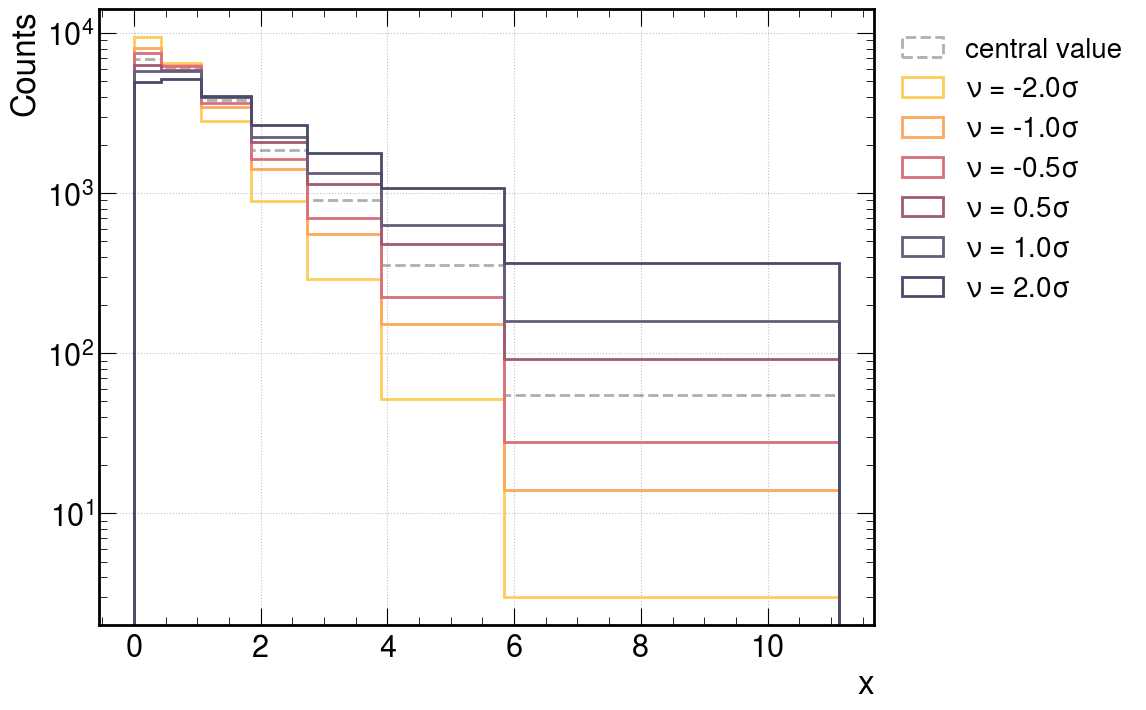

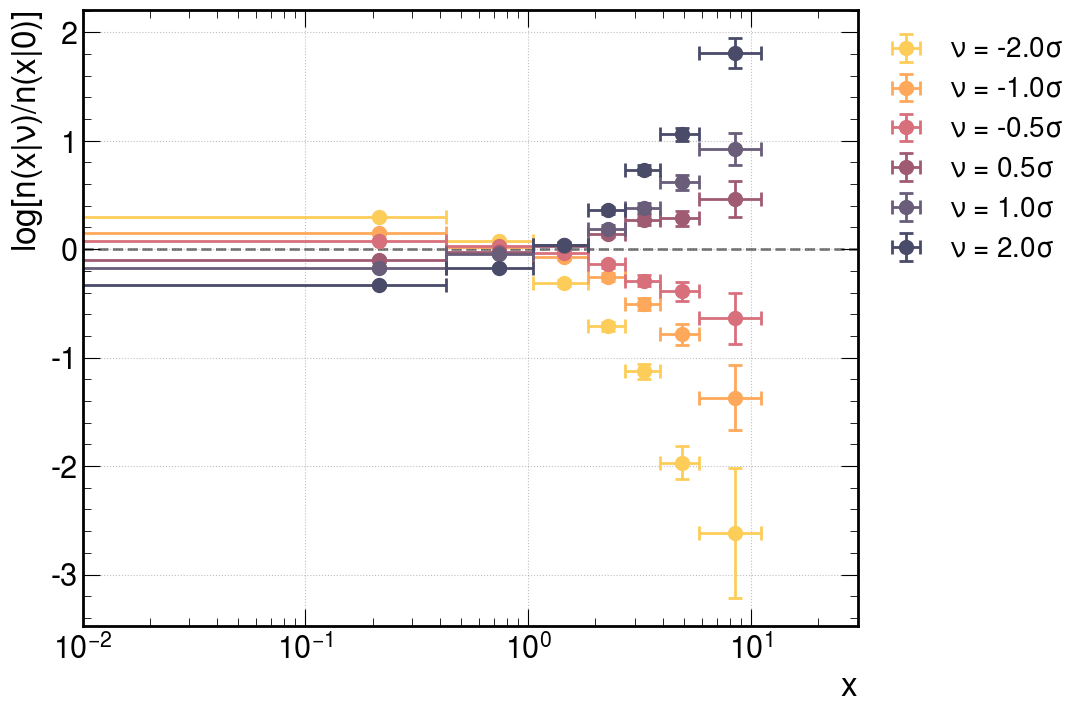

In [38]:
plot_nuisance_variations(
    feature         = feature, 
    targets         = targets, 
    weights         = weights, 
    nuisance        = nuisance, 
    nu_list         = nu_list, 
    nu_list_std     = nu_list_std, 
    bins            = bins, 
    figsize         = FIGSIZE, 
    fontsize        = FONTSIZE, 
    palette         = PALETTE_2[::-1],
    grid            = True,
    central_value   = True,
    color_centr_val = "#00000050",
    xlabel          = "x",
    ylabel          = "Counts",
    xscale          = "linear",
    yscale          = "log",
    lw              = 2,
    xlims           = None,
    ylims           = None,
)

plot_nuisance_ratio(
    feature     = feature, 
    targets     = targets, 
    weights     = weights, 
    nuisance    = nuisance, 
    nu_list     = nu_list, 
    nu_list_std = nu_list_std, 
    bins        = bins, 
    figsize     = FIGSIZE, 
    fontsize    = FONTSIZE, 
    palette     = PALETTE_2[::-1],
    grid        = True,
    zero_line   = True,
    marker      = "o",
    markersize  = 10,
    elinewidth  = 2,
    capsize     = 5,
    capthick    = 2,
    xlabel      = "x",
    ylabel      = r'$\log[n(x|\nu) / n(x|0)]$',
    xscale      = "log",
    yscale      = "linear",
    xlims       = (1e-2, 0.3e2),
    ylims       = None,
)

### Standardization

In [12]:
feature = normalize_data(feature, mean_ref, std_ref)

# Convert to PyTorch tensors after all preprocessing is done
feature  = torch.tensor(feature,  dtype=torch.float32)
targets  = torch.tensor(targets,  dtype=torch.float32)
weights  = torch.tensor(weights,  dtype=torch.float32)
nuisance = torch.tensor(nuisance, dtype=torch.float32)

# Stack the target array
target   = torch.stack([targets, weights, nuisance], dim=1)

## PARAMETRIC NETWORK

In [13]:
# split training, validation and test
fraction_validation = 0.2
fraction_test       = 0.2
fraction_training   = 1 - fraction_validation - fraction_test

# shuffle the data
n_data = feature.shape[0]
idx    = np.arange(n_data)
np.random.shuffle(idx)

# masks for splitting the data
mask_val   = (idx <  int(n_data*fraction_validation))
mask_test  = (idx >= int(n_data*fraction_validation)) * (idx < int(n_data*(fraction_validation+fraction_test)))
mask_train = (idx >= int(n_data*(fraction_validation+fraction_test)))

# split the data
feature_test,  target_test  = feature[mask_test],  target[mask_test]
feature_train, target_train = feature[mask_train], target[mask_train]
feature_val,   target_val   = feature[mask_val],   target[mask_val]

In [14]:
# create the model
model = ParametricNet(
    architecture      = LAYERS, 
    activation        = ACTIVATION, 
    poly_degree       = POLY_DEGREE, 
    initial_model     = None,
    train_coeffs      = True,
    device            = device
).to(device)
# set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# clip the initial weights of the model 
model.clip_weights(0.1)

In [15]:
# Train the model
model.train_model(
    feature_train,
    target_train,
    feature_val,
    target_val,
    EPOCHS, 
    optimizer, 
    WCLIP, 
    PATIENCE,
    GATHER_AFTER,
    BATCH_FRACTION,
)

Epoch: 100, Loss: 24.8336, Val Loss: 24.5814
Epoch: 200, Loss: 24.6367, Val Loss: 24.5801
Epoch: 300, Loss: 24.6350, Val Loss: 24.5792
Epoch: 400, Loss: 24.6342, Val Loss: 24.5789
Epoch: 500, Loss: 24.6338, Val Loss: 24.5787
Epoch: 600, Loss: 24.6336, Val Loss: 24.5786
Epoch: 700, Loss: 24.6334, Val Loss: 24.5786
Epoch: 800, Loss: 24.6334, Val Loss: 24.5786
Epoch: 900, Loss: 24.6333, Val Loss: 24.5786
Epoch: 1000, Loss: 24.6333, Val Loss: 24.5787


/tmp/ipykernel_1117438/2081003454.py:26: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio*np.sqrt( (histo_nu_sq*1./histo_nu**2) + (histo_ref_sq*1./histo_ref**2) )
/tmp/ipykernel_1117438/2081003454.py:28: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(ratio)


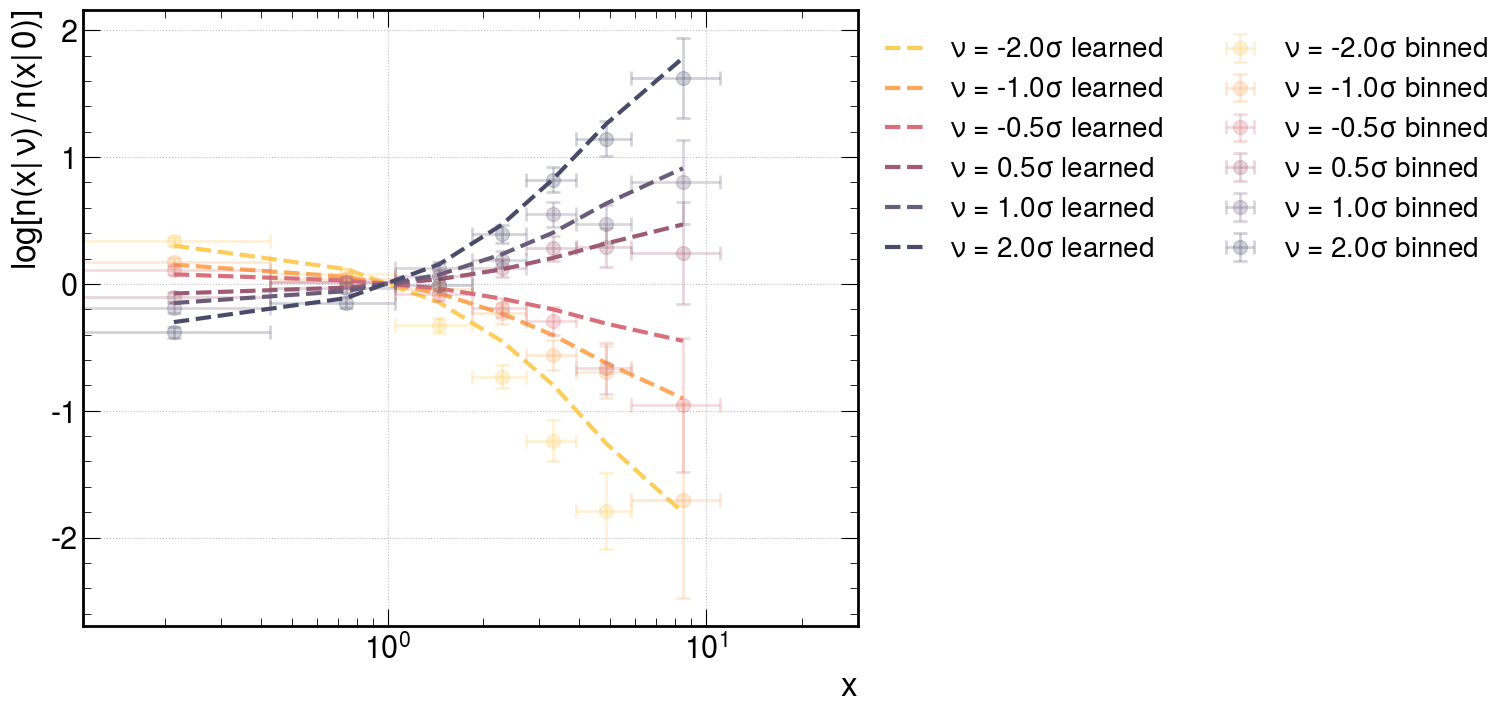

In [16]:
# create figure and axes
fig, ax = plt.subplots(figsize=FIGSIZE)
draw_grid(ax)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)


# for each nuisance parameter
for nu_iter in range(len(nu_list)):
    nu = nu_list[nu_iter]
    nu_std = nu_list_std[nu_iter]
    
    x_ref = feature_test[(target_test[:,2]==nu_std)     & (target_test[:,0]==0)][:, 0]
    w_ref = target_test[:,1][(target_test[:,2]==nu_std) & (target_test[:,0]==0)]
    
    x_nu  = feature_test[(target_test[:,2]==nu_std)     & (target_test[:,0]==1)][:, 0]
    w_nu  = target_test[:,1][(target_test[:,2]==nu_std) & (target_test[:,0]==1)]

    histo_ref = np.histogram(x_ref, bins=bins, weights=w_ref)[0]
    histo_nu  = np.histogram(x_nu,  bins=bins, weights=w_nu)[0]
    
    histo_ref_sq = np.histogram(x_ref, bins=bins, weights=w_ref**2)[0]
    histo_nu_sq  = np.histogram(x_nu,  bins=bins, weights=w_nu**2)[0]
    
    ratio = histo_nu*1./(histo_ref)
    ratio_err = ratio*np.sqrt( (histo_nu_sq*1./histo_nu**2) + (histo_ref_sq*1./histo_ref**2) )
    
    log_ratio = np.log(ratio)
    log_ratio_err = ratio_err*1./ratio
        
    # plot the already-computed binned log-ratio
    ax.errorbar(
        x          = bincenters, 
        y          = log_ratio,
        yerr       = log_ratio_err,
        xerr       = binwidths / 2,
        marker     = 'o',
        ls         = '',
        lw         = 0,
        label      = r'$\nu$ = %s$\sigma$ binned'%(str(nu)), 
        color      = PALETTE_2[::-1][nu_iter], 
        markersize = 10,
        elinewidth = 2,
        capsize    = 5,
        capthick   = 2,
        alpha      = 0.25
    )
    
    # masks to retreive the validation data corresponding to this nuisance parameter
    maskR = (target_test[:, -1]==nu_std) * (target_test[:, 0]==0)
    maskD = (target_test[:, -1]==nu_std) * (target_test[:, 0]==1)
    
    # retrieve the validation data
    featR = feature_test[maskR]
    featD = feature_test[maskD]
    
    pred_test = model(feature_test.to(device))
    poly_test = delta_nu_poly(target_test.to(device), pred_test)
    deltR = np.exp(poly_test[maskR].cpu().detach().numpy())
    
    # retreive the weights
    weig = target_test[:, 1]
    weigR = weig[maskR]
    weigD = weig[maskD]
    

    hist_sumD = np.histogram(featD[:, 0]*mean_ref[0], weights=weigD,       bins=bins)[0]
    
    # reweight the reference data
    hist_sumW = np.histogram(featR[:, 0]*mean_ref[0], weights=weigR*deltR, bins=bins)[0]
    
    hist_sum  = np.histogram(featR[:, 0]*mean_ref[0], weights=weigR,       bins=bins)[0]
    
    ax.plot(bincenters, np.log(hist_sumW/hist_sum), color=PALETTE_2[::-1][nu_iter], lw=3, ls='--', label = r'$\nu$ = %s$\sigma$ learned'%(str(nu)))


ax.set_xlabel("x")
ax.set_ylabel(r'$log[n({x}|\,\nu)\,/ \, n({x}|\,0)]$')

ax.set_xscale("log")
ax.set_xlim(1.1e-1, 0.3e2)
# ax.set_ylim(-4, 4)

ax.legend(fontsize=FONTSIZE-4, ncols=2, bbox_to_anchor=(1.0, 1.0), loc="upper left")
plt.show()